In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import shap
shap.plots.initjs()



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df_train_val = pd.read_csv('heart_failure/train_val_split.csv')
df_test = pd.read_csv('heart_failure/test_split.csv')

df = pd.concat([df_train_val, df_test], axis=0)

In [3]:
df_train_val

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [4]:
scaler = StandardScaler()

    
def create_bar_plot(names, values,title='Bar Plot'):
    plt.bar(names, values)
    plt.xlabel('Names')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks(rotation=90)
    
    plt.savefig(f'images/{title}.png')
    
    plt.show()

def standardize_data(data):
    if hasattr(scaler, 'scale_'):
        normalized_data = scaler.transform(data)
    else:
        normalized_data = scaler.fit_transform(data)
    return normalized_data

import os

def plot_binning(series, bins=10, name='data'):
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title(name)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    
    plt.savefig(f'images/{name}.png')
    
    plt.show()
    
def plot_categorical(df, column):
    counts = df[column].value_counts()

    plt.bar(counts.index, counts.values)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(f'Occurrence of Each Category in {column}')
    plt.xticks(rotation=45)
    
    plt.savefig(f'images/{column}.png')
    
    plt.show()
    
def plot_column(df, column):
    if column in categorical:
        values = df[column].value_counts()
        names = values.index
        create_bar_plot(names, values, title=column)
    elif column in nummeric:
        plot_binning(df[column], bins=100, name=column)
    else:
        print(f"Column {column} not found in categorical or nummeric lists.")
    
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
nummeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [5]:
def create_dataloaders_from_arrays(X_train, y_train, batch_size=64):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    return train_loader

def train_model(model, train_loader, test_loader, device='cpu', epochs=10):
    
    if not (device == 'cpu'):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            target = target.view(-1, 1)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        
def make_predictions(model, array):
    tensor = torch.from_numpy(array).float()

    output = model(tensor)

    probabilities = torch.sigmoid(output).detach().numpy()

    return probabilities

In [6]:
feature_names = df.columns
data_types = ['numerical' if df[col].dtype in ['int64', 'float64'] else 'categorical' for col in df.columns]
third_column = [f"{df[col].min()}-{df[col].max()}" if df[col].dtype in ['int64', 'float64'] else len(df[col].unique()) for col in df.columns]

table_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Data Type': data_types,
    'Range / Number of Categories': third_column
})

latex_code = table_df.to_latex(index=False)
print(latex_code)


\begin{tabular}{lll}
\toprule
Feature Name & Data Type & Range / Number of Categories \\
\midrule
Age & numerical & 28-77 \\
Sex & categorical & 2 \\
ChestPainType & categorical & 4 \\
RestingBP & numerical & 0-200 \\
Cholesterol & numerical & 0-603 \\
FastingBS & numerical & 0-1 \\
RestingECG & categorical & 3 \\
MaxHR & numerical & 60-202 \\
ExerciseAngina & categorical & 2 \\
Oldpeak & numerical & -2.6-6.2 \\
ST_Slope & categorical & 3 \\
HeartDisease & numerical & 0-1 \\
\bottomrule
\end{tabular}



Data Visualization and Preprocessing

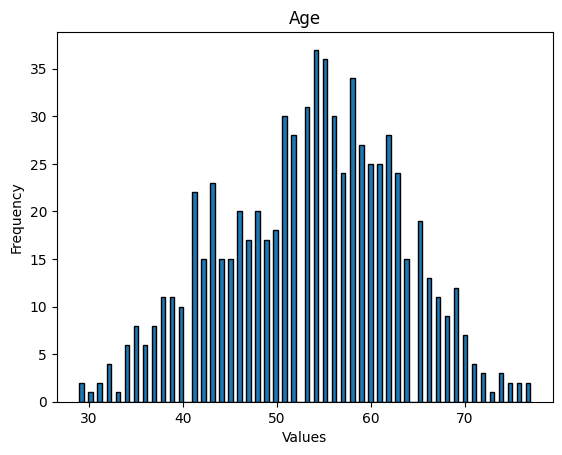

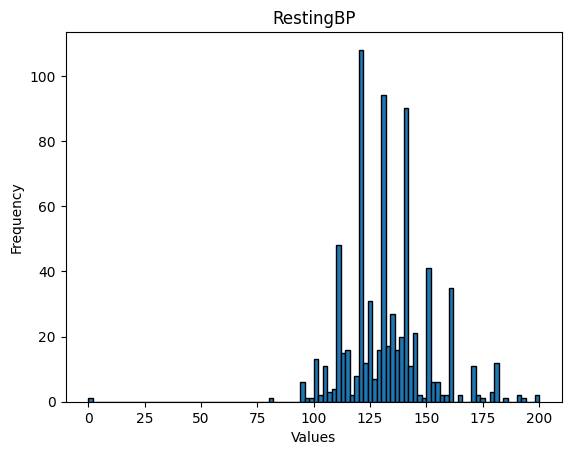

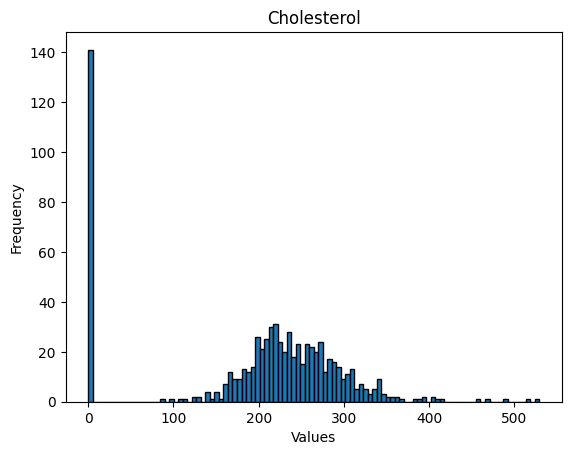

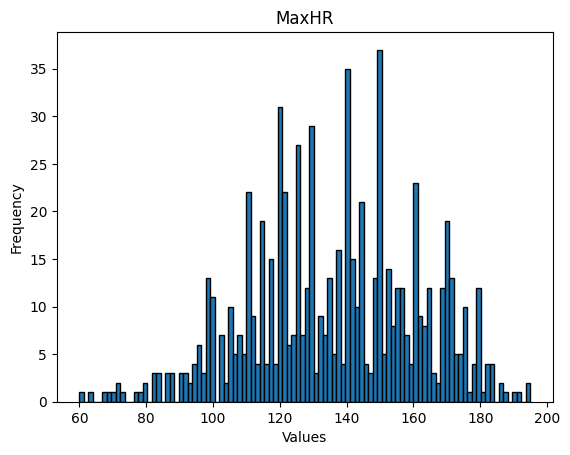

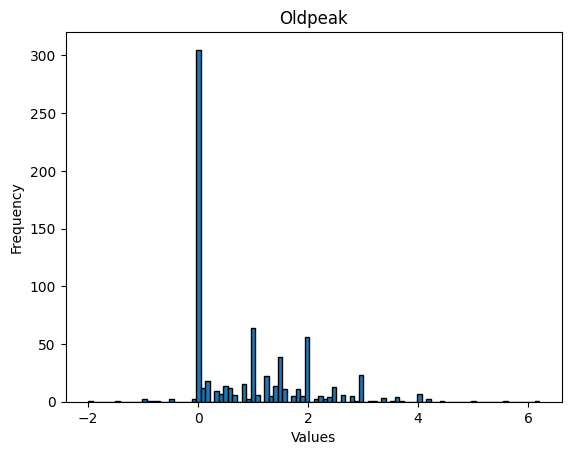

In [7]:
for col in nummeric:
    plot_column(df_train_val, column=col)

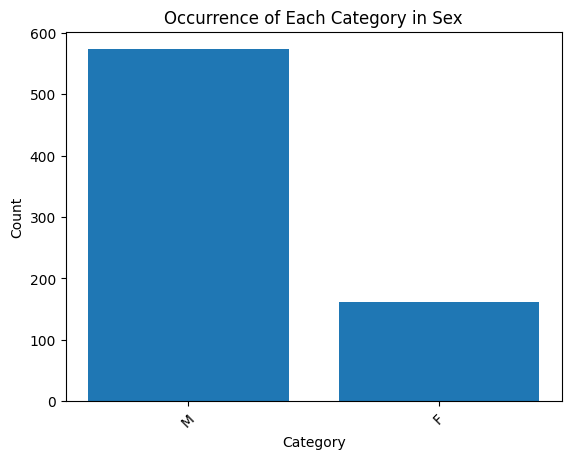

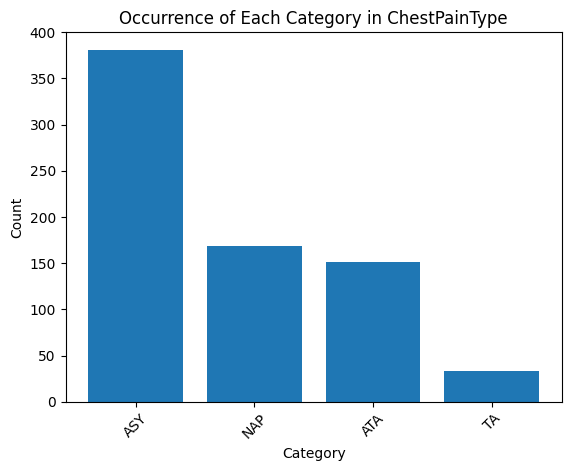

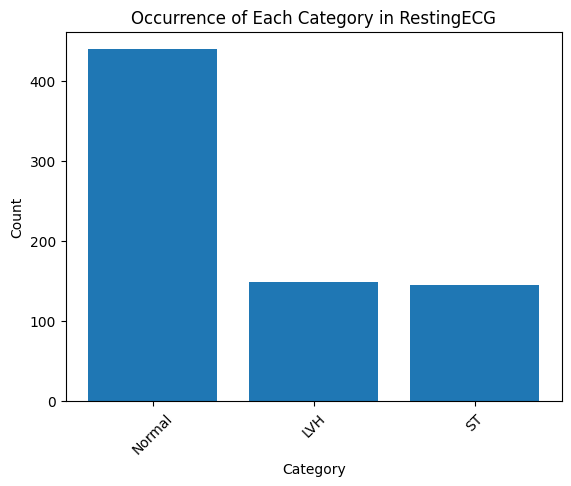

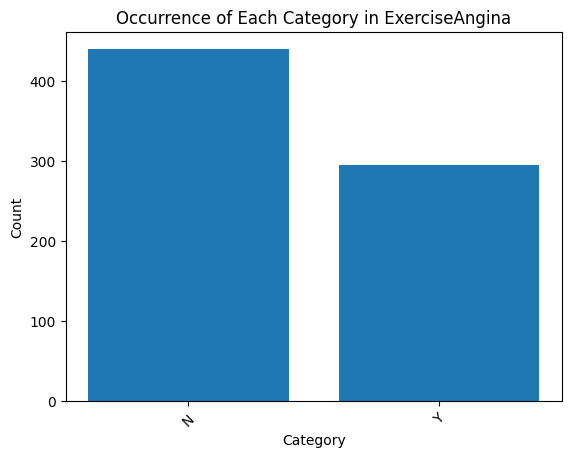

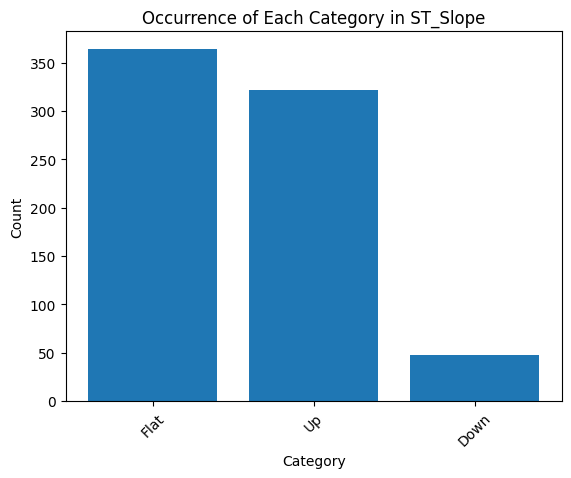

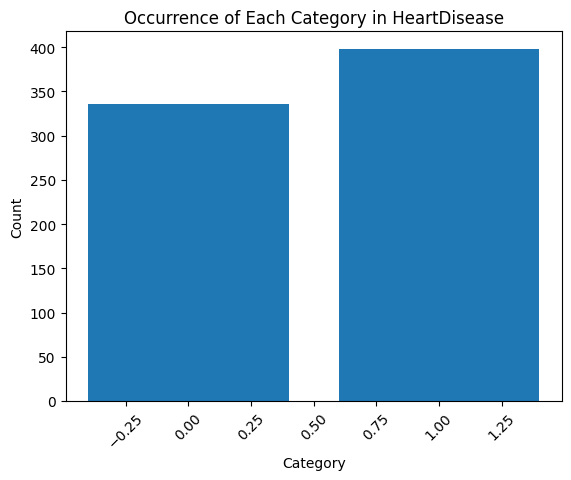

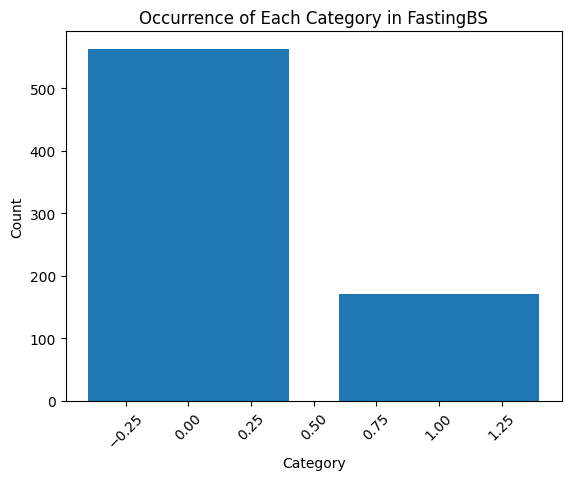

In [8]:
for col in categorical:
    plot_categorical(df_train_val, column=col)

In [9]:
'''df_train_val['Sex'] = pd.factorize(df_train_val['Sex'])[0]
df_train_val['ChestPainType'] = pd.factorize(df_train_val['ChestPainType'])[0]
df_train_val['RestingECG'] = pd.factorize(df_train_val['RestingECG'])[0]
df_train_val['ExerciseAngina'] = pd.factorize(df_train_val['ExerciseAngina'])[0]
df_train_val['ST_Slope'] = pd.factorize(df_train_val['ST_Slope'])[0]

df_test['Sex'] = pd.factorize(df_test['Sex'])[0]
df_test['ChestPainType'] = pd.factorize(df_test['ChestPainType'])[0]
df_test['RestingECG'] = pd.factorize(df_test['RestingECG'])[0]
df_test['ExerciseAngina'] = pd.factorize(df_test['ExerciseAngina'])[0]
df_test['ST_Slope'] = pd.factorize(df_test['ST_Slope'])[0]'''

df['Sex'] = pd.factorize(df['Sex'])[0]
df['ChestPainType'] = pd.factorize(df['ChestPainType'])[0]
df['RestingECG'] = pd.factorize(df['RestingECG'])[0]
df['ExerciseAngina'] = pd.factorize(df['ExerciseAngina'])[0]
df['ST_Slope'] = pd.factorize(df['ST_Slope'])[0]

df_train_val = df[:df_train_val.shape[0]]
df_test = df[df_train_val.shape[0]:]

In [10]:
X = df_train_val.drop(columns=['HeartDisease']).values
X_test = df_test.drop(columns=['HeartDisease']).values
y = df_train_val['HeartDisease'].values
y_test = df_test['HeartDisease'].values
X_st = standardize_data(X)
X_test = standardize_data(X_test)
#print(X_st)
X_train, X_val, y_train, y_val = train_test_split(X_st, y, test_size=0.2, random_state=42)
y_train

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,

Lasso Regression

In [11]:
reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
logreg = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)

In [12]:
logreg.C_[0]


0.3593813663804626

In [13]:
logreg.score(X_val, y_val)

0.8775510204081632

In [14]:
pred = logreg.predict(X_test).round()
f1Score = f1_score(y_test, pred)
bAccuracy = balanced_accuracy_score(y_test, pred)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.8348623853211009 balanced accuracy:  0.7987714987714988


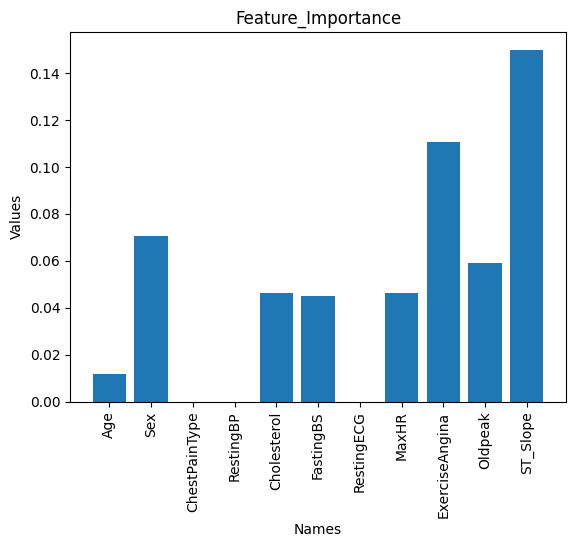

In [15]:
create_bar_plot(df_train_val.columns[0:11], np.abs(reg.coef_), title='Feature_Importance')

MLP

In [16]:
import tqdm
import copy
def model_train(model, X_train, y_train, X_val, y_val):
    loss_fn = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250  
    batch_size = 10  
    batch_start = torch.arange(0, len(X_train), batch_size)

    best_acc = - np.inf   
    best_weights = None

    for epoch in range(n_epochs):
        # print(epoch)
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    return best_acc

In [17]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(11, 10)
        #self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        #x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        #x = nn.functional.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x

In [18]:
train_loader = create_dataloaders_from_arrays(X_train, y_train, batch_size=32)
val_loader = create_dataloaders_from_arrays(X_val, y_val, batch_size=32)
test_loader = create_dataloaders_from_arrays(X_test, y_test, batch_size=32)

In [19]:
(train_loader.dataset[0])

(tensor([-0.3742, -0.5301, -0.1474,  0.4266,  0.3068, -0.5511,  0.4935,  0.1514,
          1.2199,  3.8151,  0.6181]),
 tensor(1.))

In [20]:
model = MyModel()
train_model(model, train_loader, val_loader, device='cpu', epochs=100)

Epoch: 1 	Training Loss: 0.633363
Epoch: 2 	Training Loss: 0.434404
Epoch: 3 	Training Loss: 0.369145
Epoch: 4 	Training Loss: 0.347998
Epoch: 5 	Training Loss: 0.332116
Epoch: 6 	Training Loss: 0.321801
Epoch: 7 	Training Loss: 0.318609
Epoch: 8 	Training Loss: 0.308590
Epoch: 9 	Training Loss: 0.299252
Epoch: 10 	Training Loss: 0.293408
Epoch: 11 	Training Loss: 0.285809
Epoch: 12 	Training Loss: 0.284449
Epoch: 13 	Training Loss: 0.279547
Epoch: 14 	Training Loss: 0.277208
Epoch: 15 	Training Loss: 0.275308
Epoch: 16 	Training Loss: 0.270123
Epoch: 17 	Training Loss: 0.264113
Epoch: 18 	Training Loss: 0.260764
Epoch: 19 	Training Loss: 0.257154
Epoch: 20 	Training Loss: 0.251442
Epoch: 21 	Training Loss: 0.252762
Epoch: 22 	Training Loss: 0.256146
Epoch: 23 	Training Loss: 0.249488
Epoch: 24 	Training Loss: 0.252114
Epoch: 25 	Training Loss: 0.246979
Epoch: 26 	Training Loss: 0.236940
Epoch: 27 	Training Loss: 0.235909
Epoch: 28 	Training Loss: 0.235694
Epoch: 29 	Training Loss: 0.2

In [21]:
model.to('cpu')
preds = make_predictions(model, X_test).round()
f1Score = f1_score(y_test, preds)
bAccuracy = balanced_accuracy_score(y_test, preds)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.8288288288288288 balanced accuracy:  0.783046683046683


In [22]:
def shap_predict_fn(data):
    model.eval()
    output = model(torch.tensor(data).float())
    return output.detach().numpy()
    
explainer = shap.KernelExplainer(shap_predict_fn, X_train[:20])
shap_values_1 = explainer.shap_values(X_train[0], nsamples=500)
print(y_train[0])
shap.force_plot(explainer.expected_value, shap_values_1[0], X_train[0], feature_names=df.columns[:-1])


1


In [23]:
shap_values_2 = explainer.shap_values(X_train[1], nsamples=500)
print(y_train[1])
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[1], feature_names=df.columns[:-1])
#

1


In [24]:
shap_values_2 = explainer.shap_values(X_train[2], nsamples=500)
print(y_train[3])
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[2], feature_names=df.columns[:-1])
#

0


In [25]:
shap_values_2 = explainer.shap_values(X_train[7], nsamples=500)
print(y_train[4])
shap.force_plot(explainer.expected_value, shap_values_2[0], X_train[7], feature_names=df.columns[:-1])
#

0


100%|██████████| 20/20 [00:00<00:00, 24.24it/s]


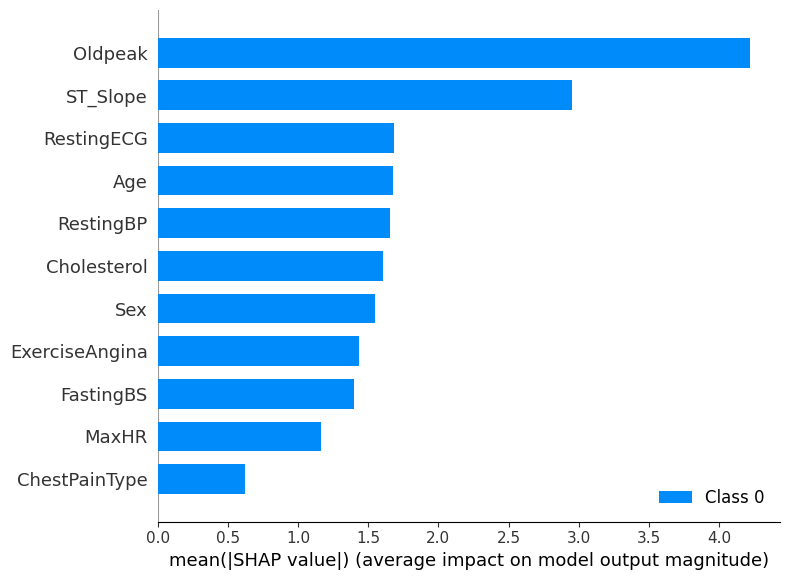

In [26]:
#explainer = shap.KernelExplainer(shap_predict_fn, X_train[:20])
shap_values = explainer.shap_values(X_train[:20], nsamples=500)
shap.summary_plot(shap_values, X_train[:20], feature_names=df.columns[:-1])


NAMs

In [27]:
class FeatureNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeatureNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.layer(x)

class My_NAM(nn.Module):
    def __init__(self, num_features):
        super(My_NAM, self).__init__()
        self.feature_nns = nn.ModuleList([FeatureNN(1, 1) for _ in range(num_features)])
        self.lastlayer = nn.Linear(num_features, 1)
        self.num_features = num_features

    def forward(self, x):
        out = torch.zeros(x.shape[0], self.num_features)
        for i, feature_nn in enumerate(self.feature_nns):
            out[:,i:i+1] += feature_nn(x[:, i:i+1])
        out = self.lastlayer(out)
        return out

In [33]:
NAM_model = My_NAM(11)
train_model(NAM_model, train_loader, val_loader, device='cuda', epochs=100)

Epoch: 1 	Training Loss: 0.450726
Epoch: 2 	Training Loss: 0.371966
Epoch: 3 	Training Loss: 0.332592
Epoch: 4 	Training Loss: 0.323569
Epoch: 5 	Training Loss: 0.319239
Epoch: 6 	Training Loss: 0.318839
Epoch: 7 	Training Loss: 0.332848
Epoch: 8 	Training Loss: 0.310686
Epoch: 9 	Training Loss: 0.320810
Epoch: 10 	Training Loss: 0.303388
Epoch: 11 	Training Loss: 0.311133
Epoch: 12 	Training Loss: 0.327575
Epoch: 13 	Training Loss: 0.316725
Epoch: 14 	Training Loss: 0.310577
Epoch: 15 	Training Loss: 0.314364
Epoch: 16 	Training Loss: 0.306785
Epoch: 17 	Training Loss: 0.303016
Epoch: 18 	Training Loss: 0.300783
Epoch: 19 	Training Loss: 0.299289
Epoch: 20 	Training Loss: 0.309840
Epoch: 21 	Training Loss: 0.297397
Epoch: 22 	Training Loss: 0.318365
Epoch: 23 	Training Loss: 0.312442
Epoch: 24 	Training Loss: 0.315057
Epoch: 25 	Training Loss: 0.303760
Epoch: 26 	Training Loss: 0.324526
Epoch: 27 	Training Loss: 0.303421
Epoch: 28 	Training Loss: 0.303509
Epoch: 29 	Training Loss: 0.3

In [29]:
print(torch.cuda.is_available())

False


In [30]:
NAM_model.to('cpu')
preds = make_predictions(NAM_model, X_test).round()
f1Score = f1_score(y_test, preds)
bAccuracy = balanced_accuracy_score(y_test, preds)
print('f1 score: ', f1Score, 'balanced accuracy: ', bAccuracy)

f1 score:  0.8508771929824561 balanced accuracy:  0.799017199017199


In [31]:
def plot_model_function(model, x_range=(-10, 10), weight=1, fn_nr=0):
    model.eval()
    x = torch.linspace(*x_range, 1000).unsqueeze(-1)
    y = model(x).detach().numpy() * weight
    plt.plot(x.numpy(), y)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(f'Model Function Feature Nr. {fn_nr}')
    plt.grid(True)
    plt.savefig(f'images/model_fn_{fn_nr}.png')
    plt.show()

(1, 11)


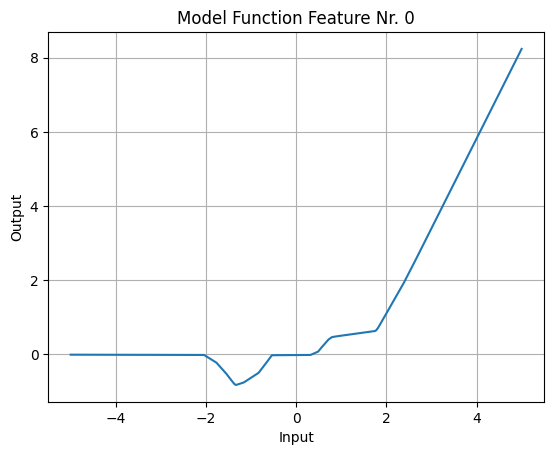

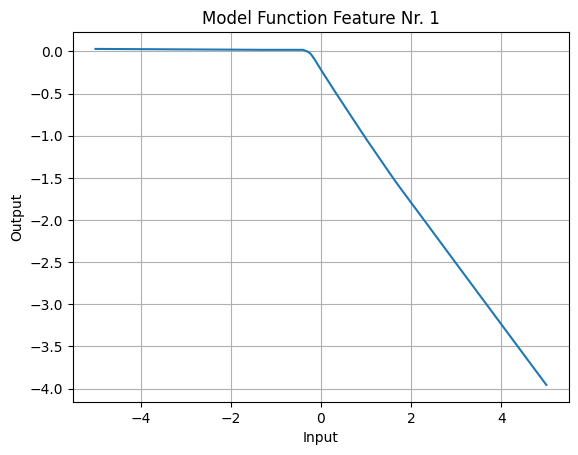

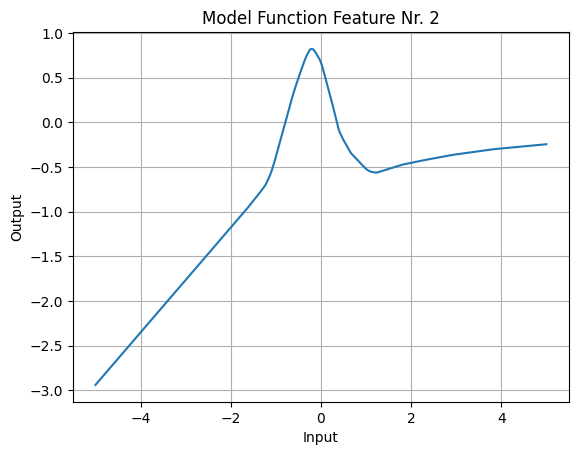

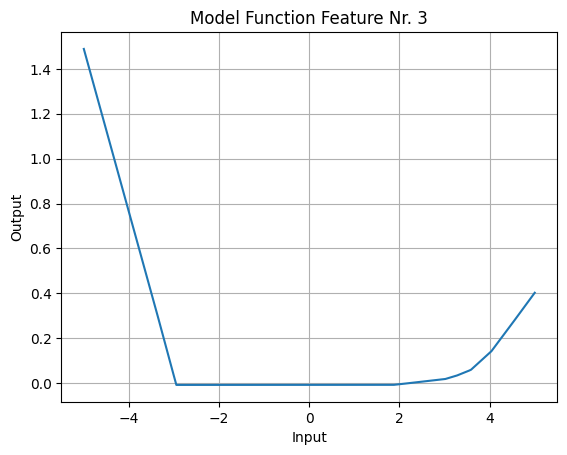

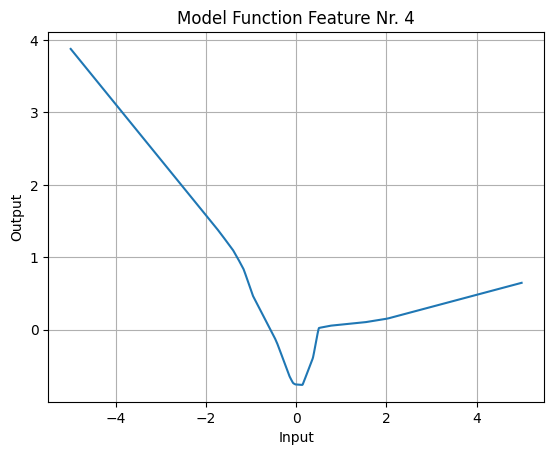

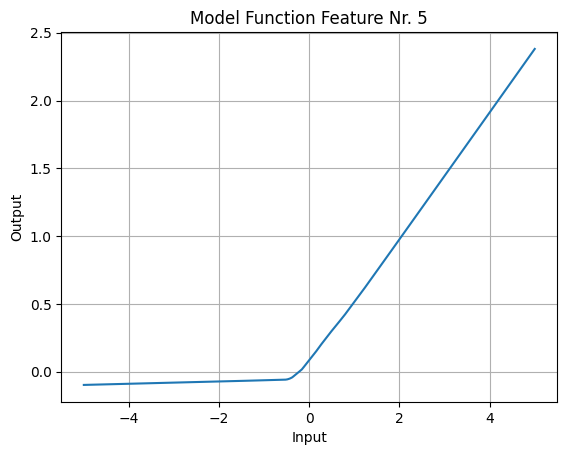

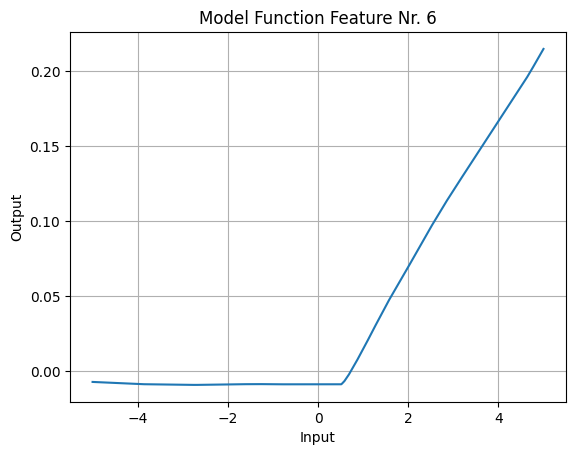

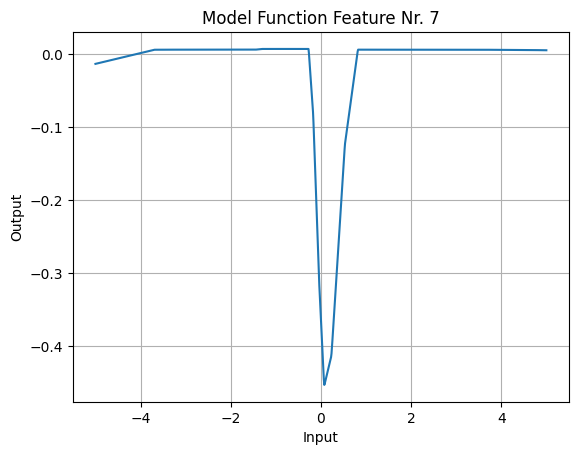

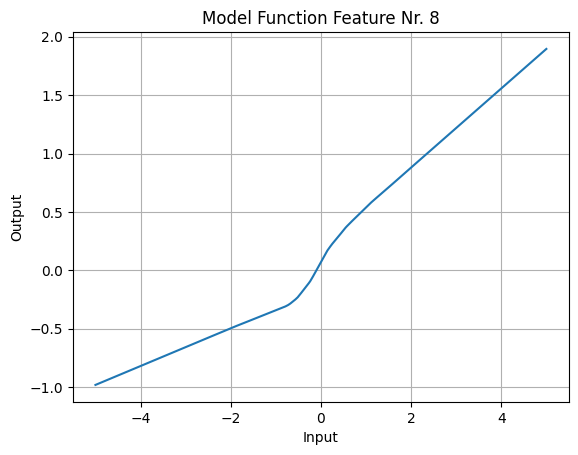

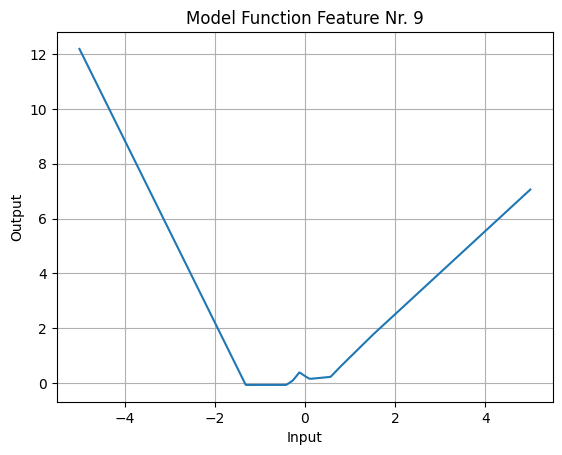

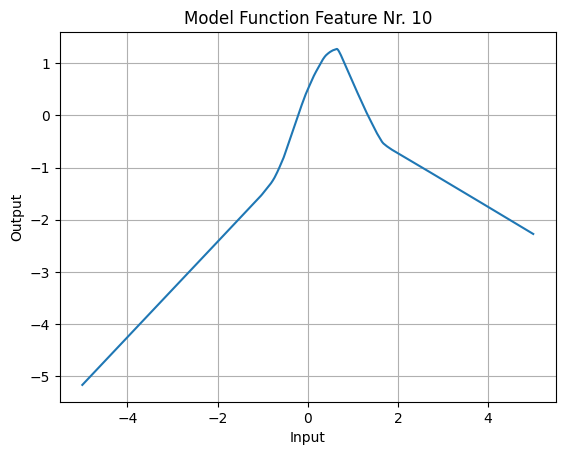

In [32]:
state_dict = NAM_model.state_dict()
feature_importances = state_dict['lastlayer.weight'].detach().numpy()
print(feature_importances.shape)
#create_bar_plot(df.columns[:-1], np.abs(feature_importances[0]))

for i,mod in enumerate(NAM_model.feature_nns):
    plot_model_function(mod, x_range=(-5, 5), weight=feature_importances[0][i], fn_nr=i)